In [1]:
from nn_generalisation.experiment import Experiment
from experiment_args import experiment_args
import matplotlib.pyplot as plt
from nn_generalisation.landscape_analysis.slope import get_jacobian_avg
from nn_generalisation.landscape_analysis.curvature import get_hessian_avg
from nn_generalisation.data.logging_utils import load_model, save_json, load_json
from nn_generalisation.neural_net import DenseNN, extend_params, test
import numpy as np
import torch
import os
import re

In [52]:
def get_landscape_metrics(path : str, sizes : list[int], exp):
	"""
	Get average slope and curvature for each model
	params:
		path: (str) path for folder containing initial and final model .pt files
		sizes: (list : int) list of the number of hidden units in the hidden layer of each model
		exp: (Experiment)
	return:
		(dict) For each experiment, for initial and final models, stores avg slope and curvature measures
	"""
	output = {n: {"initial":{"jacobian": [], "hessian": []}, "final":{"jacobian": [], "hessian": []}} for n in sizes}
	for path, dirs, files in os.walk(path):
		for file in files:
			if "initial" in file:
				num_hidden_units = int(re.findall("\d+", file)[0])
				model = load_model(num_hidden_units, os.path.join(path, file))
				jacobian_avg = get_jacobian_avg(model, exp)
				hessian_avg = get_hessian_avg(model, exp)
				output[num_hidden_units]["initial"]["jacobian"].append(jacobian_avg)
				output[num_hidden_units]["initial"]["hessian"].append(hessian_avg)
			if "final" in file:
				num_hidden_units = int(re.findall("\d+", file)[0])
				model = load_model(num_hidden_units, os.path.join(path, file))
				jacobian_avg = get_jacobian_avg(model, exp)
				hessian_avg = get_hessian_avg(model, exp)
				output[num_hidden_units]["final"]["jacobian"].append(jacobian_avg)
				output[num_hidden_units]["final"]["hessian"].append(hessian_avg)
	return output

def get_average_of_landscape_metrics(metric_dicts : list[dict], sizes : list[int]):
	output = {n: {"initial":{"jacobian": [], "hessian": []}, "final":{"jacobian": [], "hessian": []}} for n in sizes}
	for i, metric_dict in enumerate(metric_dicts):
		for key, value in metric_dict.items():
			if i == 0:
				output[key]["initial"]["jacobian"].append(value["initial"]["jacobian"][0])
				output[key]["initial"]["hessian"].append(value["initial"]["hessian"][0])
				output[key]["final"]["jacobian"].append(value["final"]["jacobian"][0])
				output[key]["final"]["hessian"].append(value["final"]["hessian"][0])
			else:
				output[key]["initial"]["jacobian"][0] += value["initial"]["jacobian"][0]
				output[key]["initial"]["hessian"][0] += value["initial"]["hessian"][0]
				output[key]["final"]["jacobian"][0] += value["final"]["jacobian"][0]
				output[key]["final"]["hessian"][0] += value["final"]["hessian"][0]
			if i == len(metric_dicts) - 1:
				output[key]["initial"]["jacobian"][0] /= len(metric_dicts)
				output[key]["initial"]["hessian"][0] /= len(metric_dicts)
				output[key]["final"]["jacobian"][0] /= len(metric_dicts)
				output[key]["final"]["hessian"][0] /= len(metric_dicts)
	return output

def get_train_test_losses(path, sizes, exp):
	output = {n: {"initial":{"train": [], "test": []}, "final":{"train": [], "test": []}} for n in sizes}
	for path, dirs, files in os.walk(path):
		for file in files:
			if "initial" in file:
				num_hidden_units = int(re.findall("\d+", file)[0])
				model = load_model(num_hidden_units, os.path.join(path, file)).to(exp.args["device"])
				train_loss = test(model, exp.train_loader, exp.args)            
				test_loss = test(model, exp.test_loader, exp.args)
				output[num_hidden_units]["initial"]["train"].append(train_loss)
				output[num_hidden_units]["initial"]["test"].append(test_loss)
			elif "final" in file:
				num_hidden_units = int(re.findall("\d+", file)[0])
				model = load_model(num_hidden_units, os.path.join(path, file)).to(exp.args["device"])
				train_loss = test(model, exp.train_loader, exp.args)            
				test_loss = test(model, exp.test_loader, exp.args)
				output[num_hidden_units]["final"]["train"].append(train_loss)
				output[num_hidden_units]["final"]["test"].append(test_loss)
	return output

def get_train_test_losses_from_log(path, sizes, exp):
	output = {n: {"initial":{"train": [], "test": []}, "final":{"train": [], "test": []}} for n in sizes}
	log = load_json(path)
	for size in sizes:
		output[size]["final"]["train"].append(log[f"model_{size}"][0][-1])
		output[size]["final"]["test"].append(log[f"model_{size}"][1][-1])
	return output

def get_average_of_train_test_losses(metric_dicts : list[dict], sizes : list[int]):
	output = {n: {"initial":{"train": [], "test": []}, "final":{"train": [], "test": []}} for n in sizes}
	for i, metric_dict in enumerate(metric_dicts):
		for key, value in metric_dict.items():
			if i == 0:
				# output[key]["initial"]["train"].append(value["initial"]["train"][0])
				# output[key]["initial"]["test"].append(value["initial"]["test"][0])
				output[key]["final"]["train"].append(value["final"]["train"][0])
				output[key]["final"]["test"].append(value["final"]["test"][0])
			else:
				# output[key]["initial"]["train"][0] += value["initial"]["train"][0]
				# output[key]["initial"]["test"][0] += value["initial"]["test"][0]
				output[key]["final"]["train"][0] += value["final"]["train"][0]
				output[key]["final"]["test"][0] += value["final"]["test"][0]
			if i == len(metric_dicts) - 1:
				# output[key]["initial"]["train"][0] /= len(metric_dicts)
				# output[key]["initial"]["test"][0] /= len(metric_dicts)
				output[key]["final"]["train"][0] /= len(metric_dicts)
				output[key]["final"]["test"][0] /= len(metric_dicts)
	return output

In [3]:
exp = Experiment(experiment_args)

In [3]:
exp.run()

Experiment Progress:   0%|          | 0/15 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [4]:
run_landscape_metrics = get_landscape_metrics("./log/2023-07-17_16;56;56/", [*range(5,80,5)], exp)

Calculate second derivative average: 100%|██████████| 36691/36691 [03:00<00:00, 202.90it/s]


In [5]:
save_json(str(run_landscape_metrics), "./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-17_16;56;56.json")

In [9]:
run_landscape_metrics

NameError: name 'run_landscape_metrics' is not defined

In [49]:
paths = ["./log/landscape_analysis/weight_reuse_landscape_metrics_2023_7_16_18;48;05.json",
         "./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-16_21;18;22.json",
         "./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-17_08;56;43.json",
         "./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-17_13;30;00.json",
         "./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-17_16;56;56.json"]
paths = ["./log/2023-07-16_18;48;05/experiment_log.json",
         "./log/2023-07-16_21;18;22/experiment_log.json",
         "./log/2023-07-17_08;56;43/experiment_log.json",
         "./log/2023-07-17_13;30;00/experiment_log.json",
         "./log/2023-07-17_16;56;56/experiment_log.json",]
#tests = []
losses = []
for path in paths:
    #tests.append(eval(load_json(path)))
    #losses.append(get_train_test_losses(path, [*range(5,80,5)], exp))
    losses.append(get_train_test_losses_from_log(path, [*range(5,80,5)], exp))

In [50]:
losses

[{5: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.6241356811523437], 'test': [0.7125582580566406]}},
  10: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.1799199981689453], 'test': [0.46958700561523437]}},
  15: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.06542032623291015], 'test': [0.4695331573486328]}},
  20: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.03692836761474609], 'test': [0.5313711730957031]}},
  25: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.0221614990234375], 'test': [0.6102938720703125]}},
  30: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.012913463592529296], 'test': [0.7033619506835938]}},
  35: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.009335848808288574], 'test': [0.7790503540039062]}},
  40: {'initial': {'train': [], 'test': []},
   'final': {'train': [0.008182209014892578], 'test': [0.8231215026855468]}},
  45: {'initial': {'trai

In [13]:
landscape_data = get_average_of_landscape_metrics(tests, [*range(5,80,5)])

In [14]:
landscape_data

{5: {'initial': {'jacobian': [0.0184000738],
   'hessian': [0.0028190866116506535]},
  'final': {'jacobian': [0.00316191796], 'hessian': [0.0031686575304348645]}},
 10: {'initial': {'jacobian': [0.0025270522],
   'hessian': [0.0011072628793504268]},
  'final': {'jacobian': [0.006743827960000001],
   'hessian': [0.0025801930408165196]}},
 15: {'initial': {'jacobian': [0.004660994],
   'hessian': [0.0014272375951008194]},
  'final': {'jacobian': [0.008218057400000001],
   'hessian': [0.0019924955495738772]}},
 20: {'initial': {'jacobian': [0.00651822418], 'hessian': [0.001295729217736]},
  'final': {'jacobian': [0.009147836320000002],
   'hessian': [0.0017219400967336301]}},
 25: {'initial': {'jacobian': [0.007426163380000001],
   'hessian': [0.001206959346137196]},
  'final': {'jacobian': [0.00880973236], 'hessian': [0.0012125918714529591]}},
 30: {'initial': {'jacobian': [0.0075681784],
   'hessian': [0.0009521177974655175]},
  'final': {'jacobian': [0.00833596718], 'hessian': [0.00089

In [37]:
tests_losses = get_train_test_losses("./log/2023-07-17_08;56;43/", [*range(5,80,5)], exp)

In [53]:
tests_losses = get_average_of_train_test_losses(losses, [*range(5,80,5)])

In [54]:
tests_losses

{5: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.5589772216796874], 'test': [0.6446698095703125]}},
 10: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.13375680847167967], 'test': [0.45978125]}},
 15: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.04993706436157226], 'test': [0.5236878759765625]}},
 20: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.027828008651733394], 'test': [0.6432016772460937]}},
 25: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.016851226997375488], 'test': [0.7169246154785155]}},
 30: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.0109229248046875], 'test': [0.7751132092285156]}},
 35: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.007843511295318604], 'test': [0.8300710742187499]}},
 40: {'initial': {'train': [], 'test': []},
  'final': {'train': [0.006264851903915405], 'test': [0.8730347387695312]}},
 45: {'initial': {'train': [], 'test': []},
  '

In [55]:
sizes = [*range(5,80,5)]
final_train = []
final_test = []
for key, val in tests_losses.items():
    final_train.append(val["final"]["train"][0])
    final_test.append(val["final"]["test"][0])

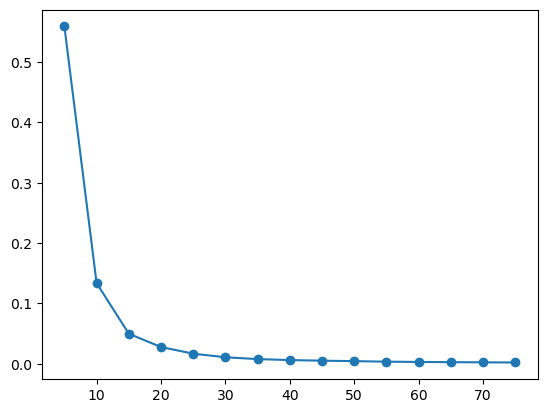

In [56]:
plt.plot(sizes,final_train, marker="o")

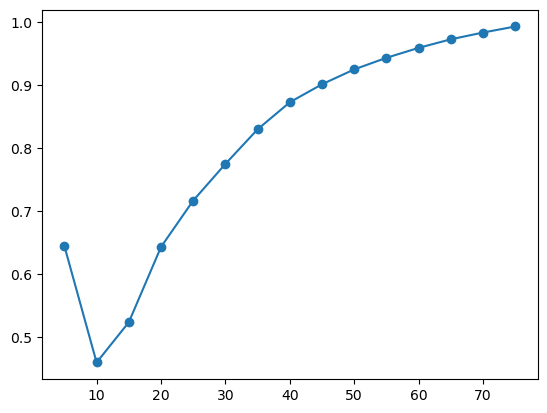

In [57]:
plt.plot(sizes, final_test, marker="o")

In [52]:
#save_json(str(output), "./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-17_08;56;43.json")
landscape_data = load_json("./log/landscape_analysis/weight_reuse_landscape_metrics_2023-07-17_08;56;43.json")

In [53]:
landscape_data = eval(landscape_data)

In [15]:
init_jacobians = []
init_hessians = []
init_ratios = []
final_jacobians = []
final_hessians = []
final_ratios = []
for key, value in landscape_data.items():
    init_jacob = value["initial"]["jacobian"][0]
    init_hess = value["initial"]["hessian"][0]
    init_jacobians.append(init_jacob)
    init_hessians.append(init_hess)
    init_ratios.append(init_jacob / init_hess)
    final_jacob = value["final"]["jacobian"][0]
    final_hess = value["final"]["hessian"][0]
    final_jacobians.append(final_jacob)
    final_hessians.append(final_hess)
    final_ratios.append(final_jacob / final_hess)

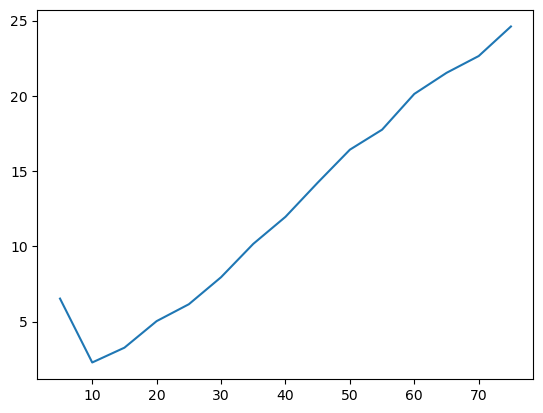

In [29]:
plt.plot([*range(5,80,5)],init_ratios)

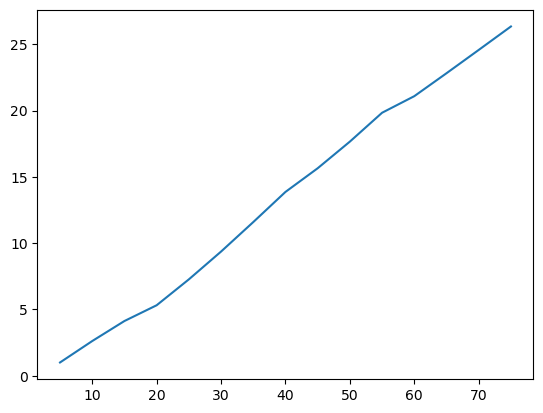

In [30]:
plt.plot([*range(5,80,5)],final_ratios)

In [58]:
comparison = []
for i in range(len(init_ratios) - 1):
    comparison.append((final_ratios[i], init_ratios[i+1]))

In [59]:
comparison

[(0.9978730517987093, 2.2822513489140803),
 (2.6136912445379945, 3.2657449719650566),
 (4.12450477079236, 5.030545032695298),
 (5.312517164419742, 6.152786673194097),
 (7.265208160635242, 7.948783669569095),
 (9.3620409263045, 10.163731011815077),
 (11.585676993338796, 11.96129076800683),
 (13.860309463133053, 14.230617459012029),
 (15.64492246894371, 16.42377393378928),
 (17.654853283618543, 17.752986194118467),
 (19.831323989004183, 20.129129805168052),
 (21.081141579345047, 21.529262462107038),
 (22.81092467583756, 22.647525592535807),
 (24.567657898198373, 24.610667102992338)]

In [18]:
diff = [j - i for (i,j) in comparison]

In [19]:
diff

[1.284378297115371,
 0.6520537274270621,
 0.9060402619029384,
 0.8402695087743544,
 0.6835755089338527,
 0.8016900855105771,
 0.37561377466803414,
 0.3703079958789761,
 0.7788514648455713,
 0.09813291049992401,
 0.29780581616386925,
 0.4481208827619909,
 -0.16339908330175135,
 0.04300920479396453]

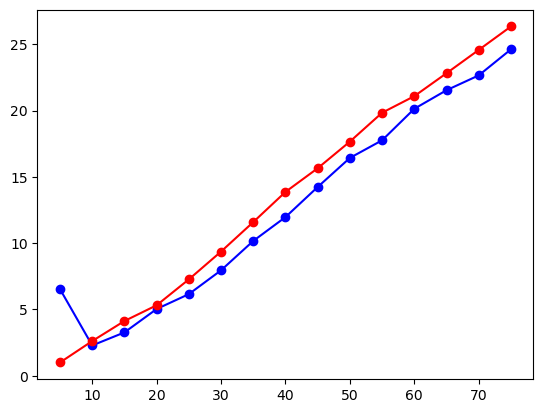

In [40]:
plt.plot([*range(5,80,5)], init_ratios, color="blue", marker="o")
plt.plot([*range(5,80,5)], final_ratios, color="red", marker="o")

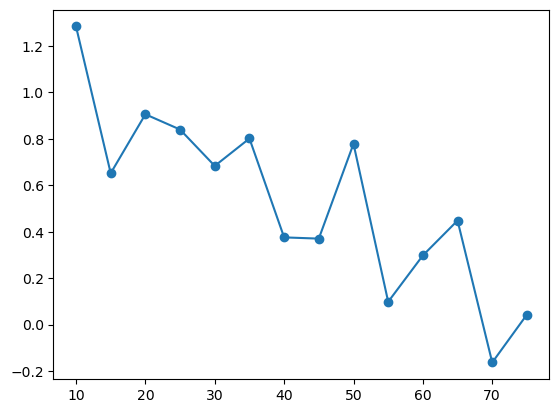

In [20]:
plt.plot([*range(5,80,5)][1:], diff, marker="o")

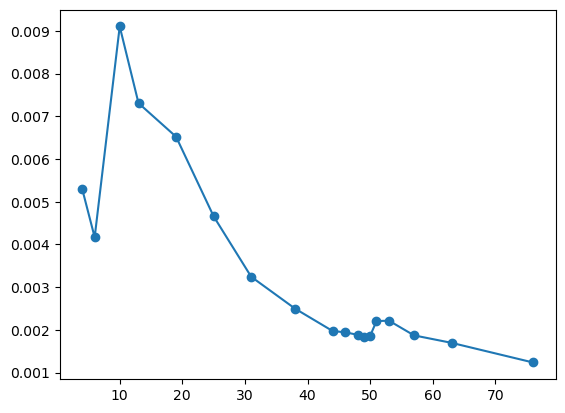

In [60]:
plt.plot([4,6,10,13,19,25,31,38,44,46,48,49,50,51,53,57,63,76], jacobians, marker="o")

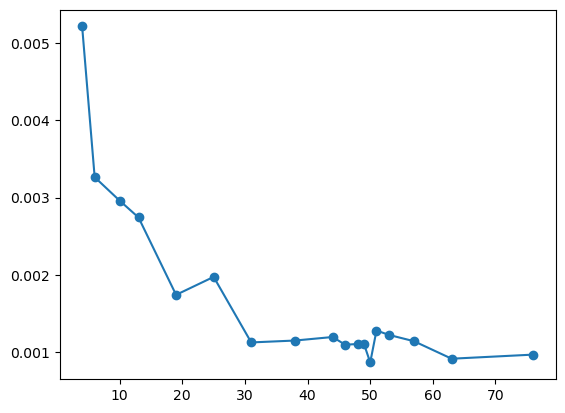

In [61]:
plt.plot([4,6,10,13,19,25,31,38,44,46,48,49,50,51,53,57,63,76], hessians, marker="o")

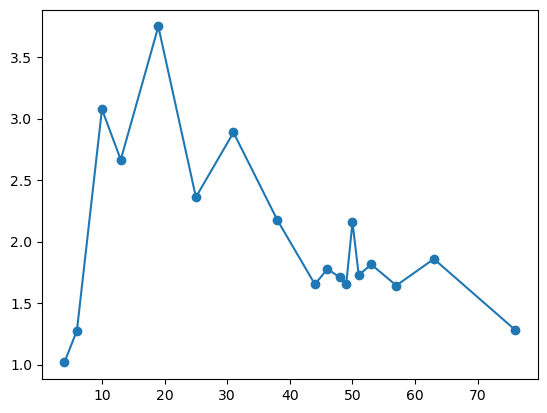

In [62]:
plt.plot([4,6,10,13,19,25,31,38,44,46,48,49,50,51,53,57,63,76], ratios, marker="o")

In [3]:
model_10 = load_model(10, r".\log\2023-07-12_18;57;33\model_size_10_final.pt")
params = model_10.get_params()
params = extend_params(params, 11, torch.device("cpu"))
model_11 = DenseNN(11)
model_11.set_params(params)
jacobian_avg_10 = get_jacobian_avg(model_10, exp)
hessian_avg_10 = get_hessian_avg(model_10, exp)
jacobian_avg_11 = get_jacobian_avg(model_11, exp)
hessian_avg_11 = get_hessian_avg(model_11, exp)
print(jacobian_avg_10)
print(hessian_avg_10)
print(f"{jacobian_avg_10 / hessian_avg_10}")
print(jacobian_avg_11)
print(hessian_avg_11)
print(f"{jacobian_avg_11 / hessian_avg_11}")

In [3]:
model_49 = load_model(49, r"C:\Users\Dave6\Documents\University\Sussex\Dissertation\dd_reproduction\mnist_standard_test\models\2023-06-30\no_weight_reuse\13;35;34\model_w_49_hidden_units_final.pt")
params = model_49.get_params()
params = extend_params(params, 50, torch.device("cpu"))
model_50 = DenseNN(50)
model_50.set_params(params)
jacobian_avg_49 = get_jacobian_avg(model_49, exp)
hessian_avg_49 = get_hessian_avg(model_49, exp)
jacobian_avg_50 = get_jacobian_avg(model_50, exp)
hessian_avg_50 = get_hessian_avg(model_50, exp)
print(jacobian_avg_49)
print(hessian_avg_49)
print(f"{jacobian_avg_49 / hessian_avg_49}")
print(jacobian_avg_50)
print(hessian_avg_50)
print(f"{jacobian_avg_50 / hessian_avg_50}")

Calculate second derivative average: 100%|██████████| 29586/29586 [02:11<00:00, 224.84it/s]

0.0018294622
0.0011209954433536735
1.6319979293042808
0.0017928822
0.0010766150758929837
1.665295480282206


In [4]:
model_76 = load_model(76, r"C:\Users\Dave6\Documents\University\Sussex\Dissertation\dd_reproduction\mnist_standard_test\models\2023-06-30\no_weight_reuse\15;18;19\model_w_76_hidden_units_final.pt")
params = model_76.get_params()
params = extend_params(params, 77, torch.device("cpu"))
model_77 = DenseNN(77)
model_77.set_params(params)
jacobian_avg_76 = get_jacobian_avg(model_76, exp)
hessian_avg_76 = get_hessian_avg(model_76, exp)
jacobian_avg_77 = get_jacobian_avg(model_77, exp)
hessian_avg_77 = get_hessian_avg(model_77, exp)
print(jacobian_avg_76)
print(hessian_avg_76)
print(f"{jacobian_avg_76 / hessian_avg_76}")
print(jacobian_avg_77)
print(hessian_avg_77)
print(f"{jacobian_avg_77 / hessian_avg_77}")


Calculate second derivative average: 100%|██████████| 46878/46878 [03:54<00:00, 199.52it/s]

0.0011504334
0.0010337652965266382
1.1128574770566946
0.0011354951
0.001007092869298908
1.1274979465105035
